In [6]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import pandas as pd
import numpy as np
import scipy
import pyro
import torch
import torch.nn.functional as F
import itertools
import copy
import json

import subprocess
import importlib

import matplotlib as mpl
mpl.rcParams.update({'text.usetex': False, 'font.size': 20})
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from flighted.common_utils import PROTEIN_ALPHABET, to_one_hot
from flighted.flighted_inference import flighted_models, flighted_trainers


import warnings
warnings.filterwarnings('default')

simulation_dir = '../Data/Selection_Simulations/'

In [9]:
selection_data = torch.load(os.path.join(simulation_dir, "selection_data.pt"))
p_sel = np.load(os.path.join(simulation_dir, "p_sel.npy"))

Text(0, 0.5, 'Fitness')

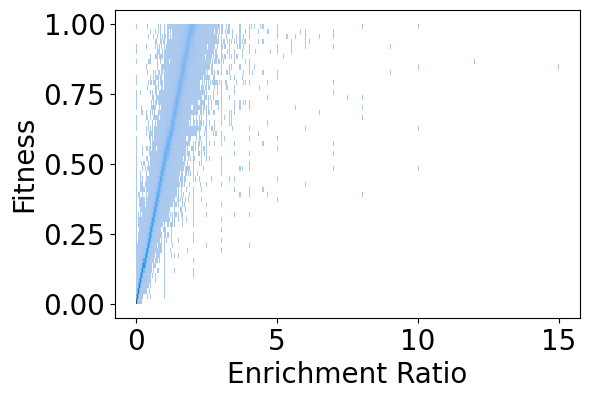

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(x=selection_data[0, :, 2] / selection_data[0, :, 1], y=p_sel, ax=ax)
ax.set_xlabel('Enrichment Ratio')
ax.set_ylabel('Fitness')

/tmp/ipykernel_384678/3353383180.py:7: RuntimeWarning: divide by zero encountered in true_divide
  enrs = (N_sampled_sel_per_var_all / N_sampled_initial_per_var_all)[:, index]
/tmp/ipykernel_384678/3353383180.py:7: RuntimeWarning: invalid value encountered in true_divide
  enrs = (N_sampled_sel_per_var_all / N_sampled_initial_per_var_all)[:, index]


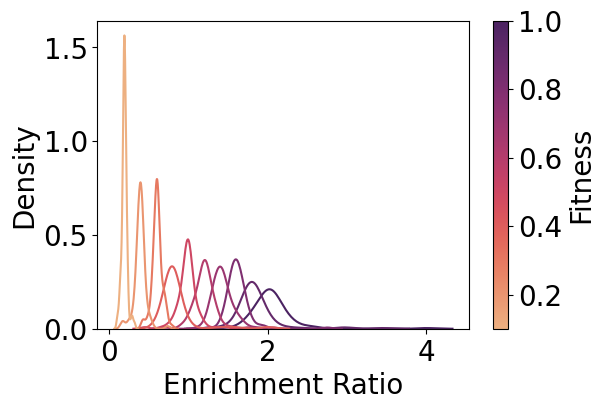

In [14]:
N_sampled_sel_per_var_all = np.array(selection_data[:, :, 2])
N_sampled_initial_per_var_all = np.array(selection_data[:, :, 1])

enr_values_dict = {'fitness': [], 'enr_ratio': []}
for fitness in np.linspace(0.1, 1, 10):
    index = np.argmin(np.abs(p_sel - fitness))
    enrs = (N_sampled_sel_per_var_all / N_sampled_initial_per_var_all)[:, index]
    enrs = enrs[~np.isinf(enrs)]
    enr_values_dict['enr_ratio'] += list(enrs)
    enr_values_dict['fitness'] += list(fitness * np.ones_like(np.array(enrs)))

enr_values_df = pd.DataFrame(enr_values_dict)

fig, ax = plt.subplots(figsize=(6, 4))
norm = plt.Normalize(0.1, 1)
sm = plt.cm.ScalarMappable(cmap='flare', norm=norm)
sns.kdeplot(data=enr_values_df, ax=ax, x='enr_ratio', hue='fitness', palette='flare')
ax.set_xlabel('Enrichment Ratio')
ax.get_legend().remove()
fig.colorbar(sm, ax=ax, label='Fitness')

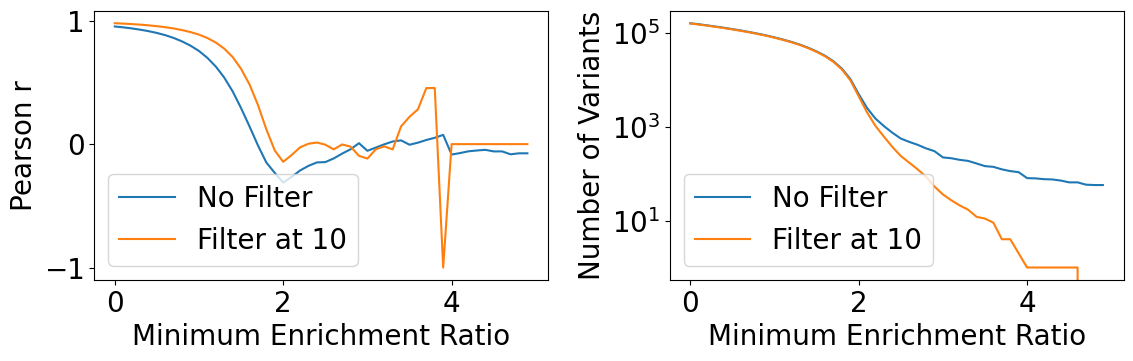

In [16]:
enr_one = selection_data[0, :, 2] / selection_data[0, :, 1]
cutoffs = np.arange(0, 5, 0.1)
size_cutoffs = [0, 10]
corrs = [[0 for _ in cutoffs] for _ in size_cutoffs]
lens = [[0 for _ in cutoffs] for _ in size_cutoffs]
for i, size_cutoff in enumerate(size_cutoffs):
    for j, cutoff in enumerate(cutoffs):
        mask = (selection_data[0, :, 1] > size_cutoff) & (enr_one > cutoff)
        lens[i][j] = len(enr_one[mask])
        if len(enr_one[mask]) > 0:
            corrs[i][j] = scipy.stats.linregress(enr_one[mask], p_sel[mask]).rvalue

fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
ax[0].plot(cutoffs, corrs[0], label='No Filter')
ax[0].plot(cutoffs, corrs[1], label='Filter at 10')
ax[0].set_xlabel('Minimum Enrichment Ratio')
ax[0].set_ylabel('Pearson r')
ax[0].legend()

ax[1].plot(cutoffs, lens[0], label='No Filter')
ax[1].plot(cutoffs, lens[1], label='Filter at 10')
ax[1].set_xlabel('Minimum Enrichment Ratio')
ax[1].set_ylabel('Number of Variants')
ax[1].legend()
ax[1].semilogy()

fig.tight_layout()

In [8]:
def convert_fitness_to_prob(x):
    return torch.clamp(torch.sigmoid(x), min=0.001, max=0.999).detach().numpy()

In [2]:
model_dir = '../Data/FLIGHTED_Selection'
p_sel = np.load(os.path.join(model_dir, 'p_sel.npy'))
selection_data = np.load(os.path.join(model_dir, 'selection_data.npy'))
train_experiments = np.load(os.path.join(model_dir, 'train_experiments.npy'))
val_experiments = np.load(os.path.join(model_dir, 'val_experiments.npy'))
test_experiments = np.load(os.path.join(model_dir, 'test_experiments.npy'))
history = pd.read_pickle(open(os.path.join(model_dir, 'history.pkl'), 'rb'))

/tmp/ipykernel_581905/3371193653.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='../Data/FLIGHTED_Selection/history.pkl'>
  history = pd.read_pickle(open(os.path.join(model_dir, 'history.pkl'), 'rb'))


In [3]:
best_model_dict = torch.load(os.path.join(model_dir, 'best_model.ckpt'), map_location=torch.device('cpu'))
hparams = json.load(open(os.path.join(model_dir, 'hparams.json'), 'r'))
model = flighted_models.FLIGHTED_Selection(hparams)
model.load_state_dict(best_model_dict['state_dict'])

/tmp/ipykernel_581905/629070182.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_dict = torch.load(os.path.join(model_dir, 'best_model.ckpt'), map_location=tor

<All keys matched successfully>

/tmp/ipykernel_384678/676510719.py:1: RuntimeWarning: divide by zero encountered in true_divide
  enr_ratios = (test_experiments[0:1, :, 2] / test_experiments[0:1, :, 1])[0]
/tmp/ipykernel_384678/676510719.py:1: RuntimeWarning: invalid value encountered in true_divide
  enr_ratios = (test_experiments[0:1, :, 2] / test_experiments[0:1, :, 1])[0]


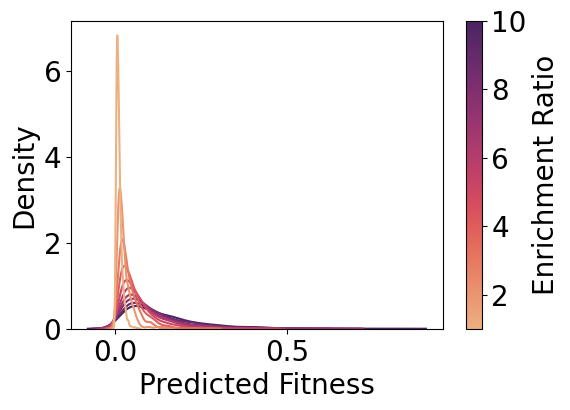

In [21]:
enr_ratios = (test_experiments[0:1, :, 2] / test_experiments[0:1, :, 1])[0]
fitness_mean, fitness_var = model.selection_reverse_model(torch.Tensor(test_experiments[0:1, :, :]))
fitness_mean = fitness_mean[0]
fitness_var = fitness_var[0]
mask = ~np.isnan(enr_ratios) & ~np.isinf(enr_ratios)
enr_ratios = enr_ratios[mask]
fitness_mean_copy = fitness_mean[mask].detach().numpy()
fitness_var_copy = fitness_var[mask].detach().numpy()
enr_values_dict = {'fitness': [], 'enr_ratio': []}
for enr_ratio in np.linspace(1, 10, 10):
    index = np.argmin(np.abs(enr_ratios - enr_ratio))
    mean = fitness_mean_copy[index]
    var = fitness_var_copy[index]
    fitnesses_sampled = scipy.stats.norm.rvs(fitness_mean_copy[index], scale=np.sqrt(F.softplus(torch.tensor(fitness_var_copy[index]))), size=(1000,))
    enr_values_dict['enr_ratio'] += list(enr_ratios[index] * np.ones_like(fitnesses_sampled))
    enr_values_dict['fitness'] += list(convert_fitness_to_prob(torch.tensor(fitnesses_sampled)))

enr_values_df = pd.DataFrame(enr_values_dict)

fig, ax = plt.subplots(figsize=(6, 4))
norm = plt.Normalize(1, 10)
sm = plt.cm.ScalarMappable(cmap='flare', norm=norm)
sns.kdeplot(data=enr_values_df, ax=ax, x='fitness', hue='enr_ratio', palette='flare')
ax.set_xlabel('Predicted Fitness')
ax.get_legend().remove()
fig.colorbar(sm, ax=ax, label='Enrichment Ratio')

0.9525039599919596 0.948535053427418 0.9573486573966461
-0.9663660214890285 -0.970301166431267 -0.961741375018906


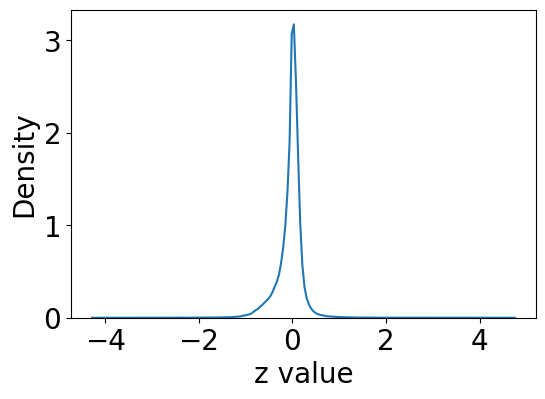

In [22]:
rvals = []
error_probs = []
for exp in range(10):
    fitness_mean, fitness_var = model.selection_reverse_model(torch.Tensor(test_experiments[exp:exp+1, :, :]))
    mask = (test_experiments[exp:exp+1, :, 1] > 0)[0]
    fitness_mean = fitness_mean[0]
    fitness_var = fitness_var[0]
    predicted_prob_one = convert_fitness_to_prob(fitness_mean)
    predicted_prob_err = [convert_fitness_to_prob(fitness_mean) - convert_fitness_to_prob(fitness_mean - torch.sqrt(F.softplus(fitness_var))), convert_fitness_to_prob(fitness_mean + torch.sqrt(F.softplus(fitness_var))) - convert_fitness_to_prob(fitness_mean)]
        
    lin_fit = scipy.stats.linregress(predicted_prob_one[mask], p_sel[mask])  
    scaled_probs = (p_sel - lin_fit.intercept) / lin_fit.slope
    scaled_logit_probs = torch.special.logit(torch.Tensor(scaled_probs), eps=0.001).numpy()
    err_sigmoid = (scaled_logit_probs - fitness_mean.detach().numpy()) / torch.sqrt(F.softplus(fitness_var)).detach().numpy()
    
    if exp == 0:
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.kdeplot(err_sigmoid, ax=ax)
        ax.set_xlabel('z value')
        ax.set_ylabel('Density')
    
    rval = lin_fit.rvalue
    rvals += [rval]
    
    error_probs += [np.mean(scipy.stats.norm.logpdf(err_sigmoid))]
print(np.mean(rvals), min(rvals), max(rvals))
print(np.mean(error_probs), min(error_probs), max(error_probs))

In [23]:
N_sampleds = [(1e5, 1e5), (1e5, 1e6), (1e5, 1e7), (1e5, 1e8), (1e6, 1e5), (1e6, 1e6), (1e6, 1e7), (1e6, 1e8), (1e7, 1e5), (1e7, 1e6), (1e7, 1e7), (1e7, 1e8), (1e8, 1e5), (1e8, 1e6), (1e8, 1e7), (1e8, 1e8)]
error_probs_all = []
err_sigmoids_all = []
for N_sampled_initial, N_sampled in N_sampleds:
    N_tot_initial = 1e11
    num_var = 20**4
    num_exp = 10
    N_initial_per_var = N_tot_initial * np.random.dirichlet([1 for _ in range(num_var)], num_exp)
    N_initial_per_var = np.array([[int(val) for val in vallist] for vallist in N_initial_per_var])
    N_tot_initial = np.sum(N_initial_per_var, axis=1)
    p_sel_new = np.random.uniform(0, 1, (num_var,))

    N_sampled_initial_per_var_all = []
    N_sampled_sel_per_var_all = []
    N_sampled_initial_array = []
    N_sampled_array = []
    for i in range(num_exp):
        N_sampled_initial_per_var = np.random.multinomial(
            N_sampled_initial, N_initial_per_var[i, :] / N_tot_initial[i]
        )
        N_sampled_initial_per_var_all += [N_sampled_initial_per_var]
        N_sel_per_var = np.array(
            [np.random.binomial(init, sel) for init, sel in zip(N_initial_per_var[i, :], p_sel_new)]
        )
        N_sampled_sel_per_var = np.random.multinomial(N_sampled, N_sel_per_var / np.sum(N_sel_per_var))
        N_sampled_sel_per_var_all += [N_sampled_sel_per_var]
        N_sampled_initial_array += [np.tile(N_sampled_initial, (num_var,))]
        N_sampled_array += [np.tile(N_sampled, (num_var,))]

    N_sampled_initial_per_var_all = np.array(N_sampled_initial_per_var_all)
    N_sampled_sel_per_var_all = np.array(N_sampled_sel_per_var_all)
    N_sampled_initial_array = np.array(N_sampled_initial_array)
    N_sampled_array = np.array(N_sampled_array)

    test_selection_data = np.vstack(
        (
            np.tile(np.arange(num_var), (1, num_exp, 1)),
            N_sampled_initial_per_var_all[np.newaxis, :],
            N_sampled_sel_per_var_all[np.newaxis, :],
            N_sampled_initial_array[np.newaxis, :],
            N_sampled_array[np.newaxis, :]
        )
    )
    test_selection_data = torch.tensor(test_selection_data, dtype=torch.int64)
    test_selection_data = test_selection_data.permute(1, 2, 0)
    rvals = []
    error_probs = []
    err_sigmoids = []
    for exp in range(10):
        fitness_mean, fitness_var = model.selection_reverse_model(torch.Tensor(test_selection_data[exp:exp+1, :, :]))
        mask_fit = (test_selection_data[exp:exp+1, :, 1] > 20)[0]
        if len(p_sel_new[mask_fit]) == 0:
            mask_fit = (test_selection_data[exp:exp+1, :, 1] > 5)[0]
        fitness_mean = fitness_mean[0]
        fitness_var = fitness_var[0]
        predicted_prob_one = convert_fitness_to_prob(fitness_mean)
        predicted_prob_err = [convert_fitness_to_prob(fitness_mean) - convert_fitness_to_prob(fitness_mean - torch.sqrt(F.softplus(fitness_var))), convert_fitness_to_prob(fitness_mean + torch.sqrt(F.softplus(fitness_var))) - convert_fitness_to_prob(fitness_mean)]

        lin_fit = scipy.stats.linregress(predicted_prob_one[mask_fit], p_sel_new[mask_fit])  
        scaled_probs = (p_sel_new - lin_fit.intercept) / lin_fit.slope
        scaled_logit_probs = torch.special.logit(torch.Tensor(scaled_probs), eps=0.001).numpy()
        err_sigmoid = (scaled_logit_probs - fitness_mean.detach().numpy()) / torch.sqrt(F.softplus(fitness_var)).detach().numpy()

        rval = lin_fit.rvalue
        rvals += [rval]

        error_probs += [np.mean(scipy.stats.norm.logpdf(err_sigmoid))]
        err_sigmoids += [err_sigmoid]
    error_probs_all += [error_probs]
    err_sigmoids_all += [err_sigmoids]

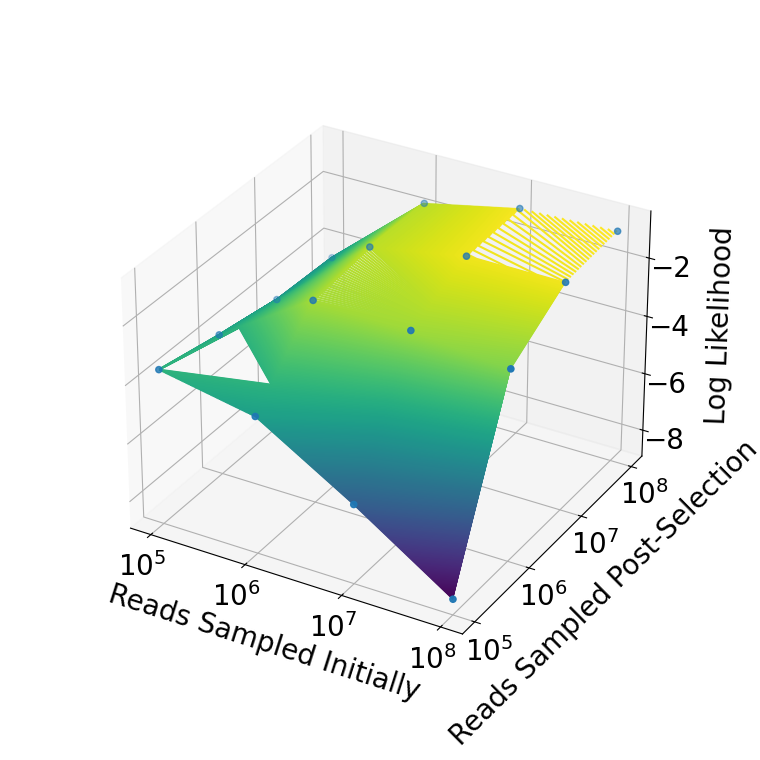

In [24]:
import matplotlib.ticker as mticker

N_sampleds = np.array(N_sampleds)

def log_tick_formatter(val, pos=None):
    return r"$10^{{{:.0f}}}$".format(val)

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(np.log10(N_sampleds[:, 0]), np.log10(N_sampleds[:, 1]), np.mean(error_probs_all, axis=1))
ax.contour3D([5, 6, 7, 8], [5, 6, 7, 8], np.mean(error_probs_all, axis=1).reshape(4, 4).transpose(), levels=1000, extend='both')
ax.set_xticks([5, 6, 7, 8])
ax.set_yticks([5, 6, 7, 8])
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.set_xlabel('Reads Sampled Initially', labelpad=20)
ax.set_ylabel('Reads Sampled Post-Selection', labelpad=20)
ax.set_zlabel('Log Likelihood', labelpad=20)
ax.set_box_aspect(aspect=None, zoom=0.8)
ax.zaxis._axinfo['label']['space_factor'] = 3
ax.axhline(20**4)
fig.tight_layout()

In [25]:
num_vars = 1600 * np.array([1, 10, 100, 1000])
error_probs_all = []
for num_var in num_vars:
    N_tot_initial = 1e11
    num_exp = 10
    N_sampled_initial = 1e8
    N_sampled = 1e8
    N_initial_per_var = N_tot_initial * np.random.dirichlet([1 for _ in range(num_var)], num_exp)
    N_initial_per_var = np.array([[int(val) for val in vallist] for vallist in N_initial_per_var])
    N_tot_initial = np.sum(N_initial_per_var, axis=1)
    p_sel_new = np.random.uniform(0, 1, (num_var,))

    N_sampled_initial_per_var_all = []
    N_sampled_sel_per_var_all = []
    N_sampled_initial_array = []
    N_sampled_array = []
    for i in range(num_exp):
        N_sampled_initial_per_var = np.random.multinomial(
            N_sampled_initial, N_initial_per_var[i, :] / N_tot_initial[i]
        )
        N_sampled_initial_per_var_all += [N_sampled_initial_per_var]
        N_sel_per_var = np.array(
            [np.random.binomial(init, sel) for init, sel in zip(N_initial_per_var[i, :], p_sel_new)]
        )
        N_sampled_sel_per_var = np.random.multinomial(N_sampled, N_sel_per_var / np.sum(N_sel_per_var))
        N_sampled_sel_per_var_all += [N_sampled_sel_per_var]
        N_sampled_initial_array += [np.tile(N_sampled_initial, (num_var,))]
        N_sampled_array += [np.tile(N_sampled, (num_var,))]

    N_sampled_initial_per_var_all = np.array(N_sampled_initial_per_var_all)
    N_sampled_sel_per_var_all = np.array(N_sampled_sel_per_var_all)
    N_sampled_initial_array = np.array(N_sampled_initial_array)
    N_sampled_array = np.array(N_sampled_array)

    test_selection_data = np.vstack(
        (
            np.tile(np.arange(num_var), (1, num_exp, 1)),
            N_sampled_initial_per_var_all[np.newaxis, :],
            N_sampled_sel_per_var_all[np.newaxis, :],
            N_sampled_initial_array[np.newaxis, :],
            N_sampled_array[np.newaxis, :]
        )
    )
    test_selection_data = torch.tensor(test_selection_data, dtype=torch.int64)
    test_selection_data = test_selection_data.permute(1, 2, 0)
    rvals = []
    error_probs = []
    for exp in range(10):
        fitness_mean, fitness_var = model.selection_reverse_model(torch.Tensor(test_selection_data[exp:exp+1, :, :]))
        mask_fit = (test_selection_data[exp:exp+1, :, 1] > 20)[0]
        if len(p_sel_new[mask_fit]) == 0:
            mask_fit = (test_selection_data[exp:exp+1, :, 1] > 5)[0]
        fitness_mean = fitness_mean[0]
        fitness_var = fitness_var[0]
        predicted_prob_one = convert_fitness_to_prob(fitness_mean)
        predicted_prob_err = [convert_fitness_to_prob(fitness_mean) - convert_fitness_to_prob(fitness_mean - torch.sqrt(F.softplus(fitness_var))), convert_fitness_to_prob(fitness_mean + torch.sqrt(F.softplus(fitness_var))) - convert_fitness_to_prob(fitness_mean)]

        lin_fit = scipy.stats.linregress(predicted_prob_one[mask_fit], p_sel_new[mask_fit])  
        scaled_probs = (p_sel_new - lin_fit.intercept) / lin_fit.slope
        scaled_logit_probs = torch.special.logit(torch.Tensor(scaled_probs), eps=0.001).numpy()
        err_sigmoid = (scaled_logit_probs - fitness_mean.detach().numpy()) / torch.sqrt(F.softplus(fitness_var)).detach().numpy()

        rval = lin_fit.rvalue
        rvals += [rval]

        error_probs += [np.mean(scipy.stats.norm.logpdf(err_sigmoid))]
    error_probs_all += [error_probs]

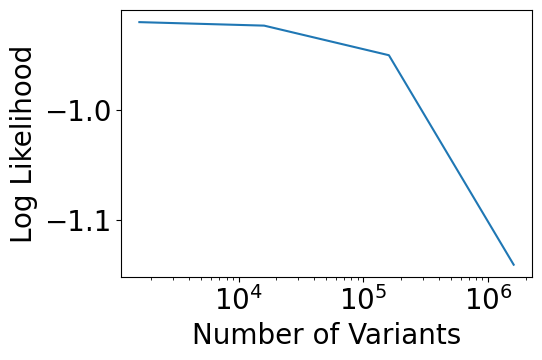

In [26]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(num_vars, np.mean(error_probs_all, axis=1))
ax.semilogx()
ax.set_xlabel('Number of Variants')
ax.set_ylabel('Log Likelihood')
fig.tight_layout()

In [27]:
import tqdm

prob_params = [(0.1, 1), (0.1, 10), (0.1, 100), (1, 1), (1, 10), (1, 100), (10, 1), (10, 10), (10, 100)]
error_probs_all = []
for dirichlet_param, beta_param in tqdm.tqdm(prob_params):
    N_tot_initial = 1e11
    num_exp = 10
    N_sampled_initial = 1e8
    N_sampled = 1e8
    N_initial_per_var = N_tot_initial * np.random.dirichlet([dirichlet_param for _ in range(num_var)], num_exp)
    N_initial_per_var = np.array([[int(val) for val in vallist] for vallist in N_initial_per_var])
    N_tot_initial = np.sum(N_initial_per_var, axis=1)
    p_sel_new = np.random.beta(1, beta_param, (num_var,))

    N_sampled_initial_per_var_all = []
    N_sampled_sel_per_var_all = []
    N_sampled_initial_array = []
    N_sampled_array = []
    for i in range(num_exp):
        N_sampled_initial_per_var = np.random.multinomial(
            N_sampled_initial, N_initial_per_var[i, :] / N_tot_initial[i]
        )
        N_sampled_initial_per_var_all += [N_sampled_initial_per_var]
        N_sel_per_var = np.array(
            [np.random.binomial(init, sel) for init, sel in zip(N_initial_per_var[i, :], p_sel_new)]
        )
        N_sampled_sel_per_var = np.random.multinomial(N_sampled, N_sel_per_var / np.sum(N_sel_per_var))
        N_sampled_sel_per_var_all += [N_sampled_sel_per_var]
        N_sampled_initial_array += [np.tile(N_sampled_initial, (num_var,))]
        N_sampled_array += [np.tile(N_sampled, (num_var,))]

    N_sampled_initial_per_var_all = np.array(N_sampled_initial_per_var_all)
    N_sampled_sel_per_var_all = np.array(N_sampled_sel_per_var_all)
    N_sampled_initial_array = np.array(N_sampled_initial_array)
    N_sampled_array = np.array(N_sampled_array)

    test_selection_data = np.vstack(
        (
            np.tile(np.arange(num_var), (1, num_exp, 1)),
            N_sampled_initial_per_var_all[np.newaxis, :],
            N_sampled_sel_per_var_all[np.newaxis, :],
            N_sampled_initial_array[np.newaxis, :],
            N_sampled_array[np.newaxis, :]
        )
    )
    test_selection_data = torch.tensor(test_selection_data, dtype=torch.int64)
    test_selection_data = test_selection_data.permute(1, 2, 0)
    rvals = []
    error_probs = []
    for exp in range(10):
        fitness_mean, fitness_var = model.selection_reverse_model(torch.Tensor(test_selection_data[exp:exp+1, :, :]))
        mask_fit = (test_selection_data[exp:exp+1, :, 1] > 20)[0]
        if len(p_sel_new[mask_fit]) == 0:
            mask_fit = (test_selection_data[exp:exp+1, :, 1] > 5)[0]
        fitness_mean = fitness_mean[0]
        fitness_var = fitness_var[0]
        predicted_prob_one = convert_fitness_to_prob(fitness_mean)
        predicted_prob_err = [convert_fitness_to_prob(fitness_mean) - convert_fitness_to_prob(fitness_mean - torch.sqrt(F.softplus(fitness_var))), convert_fitness_to_prob(fitness_mean + torch.sqrt(F.softplus(fitness_var))) - convert_fitness_to_prob(fitness_mean)]

        lin_fit = scipy.stats.linregress(predicted_prob_one[mask_fit], p_sel_new[mask_fit])  
        scaled_probs = (p_sel_new - lin_fit.intercept) / lin_fit.slope
        scaled_logit_probs = torch.special.logit(torch.Tensor(scaled_probs), eps=0.001).numpy()
        err_sigmoid = (scaled_logit_probs - fitness_mean.detach().numpy()) / torch.sqrt(F.softplus(fitness_var)).detach().numpy()

        rval = lin_fit.rvalue
        rvals += [rval]

        error_probs += [np.mean(scipy.stats.norm.logpdf(err_sigmoid))]
    error_probs_all += [error_probs]

100%|████████████████████████████████████████████████████████████████| 9/9 [21:27<00:00, 143.06s/it]


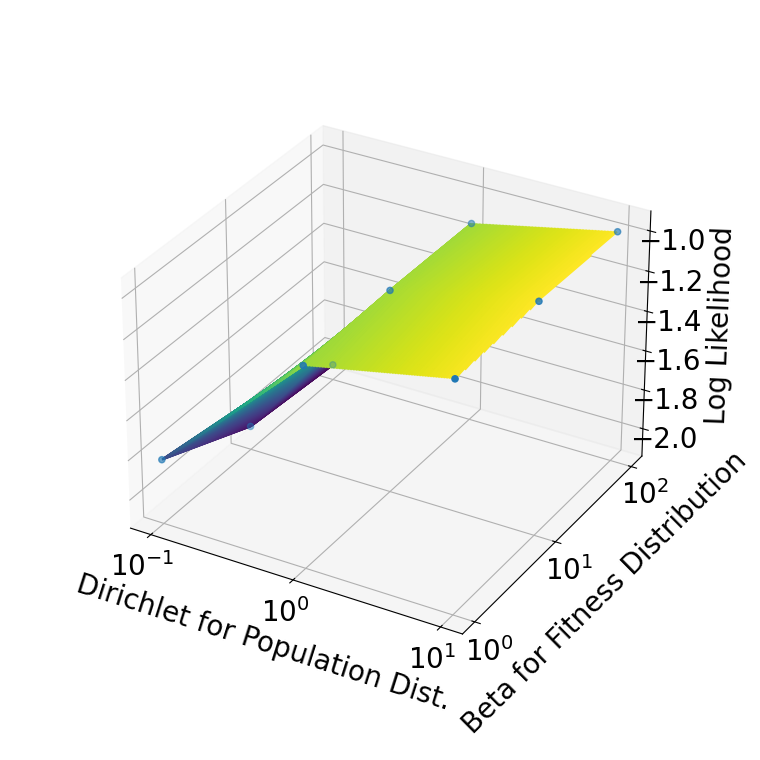

In [28]:
import matplotlib.ticker as mticker

prob_params = np.array(prob_params)

def log_tick_formatter(val, pos=None):
    return r"$10^{{{:.0f}}}$".format(val)

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(np.log10(prob_params[:, 0]), np.log10(prob_params[:, 1]), np.mean(error_probs_all, axis=1))
ax.contour3D([-1, 0, 1], [0, 1, 2], np.mean(error_probs_all, axis=1).reshape(3, 3).transpose(), levels=1000, extend='both')
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1, 2])
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.set_xlabel('Dirichlet for Population Dist.', labelpad=20)
ax.set_ylabel('Beta for Fitness Distribution', labelpad=20)
ax.set_zlabel('Log Likelihood', labelpad=20)
ax.set_box_aspect(aspect=None, zoom=0.8)
ax.zaxis._axinfo['label']['space_factor'] = 3
fig.tight_layout()

In [4]:
# from OpenAI o4-mini-high
def negative_multinomial(n, pvals, succ_index):
    p = np.asarray(pvals, dtype=float)
    if p.ndim != 1:
        raise ValueError("`pvals` must be a 1-D array of probabilities")
    if np.any(p < 0):
        raise ValueError("`pvals` must be non-negative")
    if not np.isclose(p.sum(), 1.0):
        raise ValueError("`pvals` must sum to 1.0")

    if succ_index == 0:
        p_fail = p[1:]
        p_succ = p[0]
    elif succ_index == pvals.size - 1:
        p_fail = p[:-1]
        p_succ = p[-1]
    else:
        p_fail = np.array(list(p[:succ_index]) + list(p[succ_index+1:]))
        p_succ = p[succ_index]

    if p_succ == 1.0:
        if size is None:
            return np.array([n])
        out = np.zeros(size + (1,), dtype=int)
        out[..., 0] = n
        return out

    p_fail_norm = p_fail / (1.0 - p_succ)

    try:
        total_failures = scipy.stats.nbinom(n, p_succ).rvs()
    except ValueError as e:
        print(n, p_succ)
        raise e

    def _alloc(tf):
        fails = np.random.multinomial(int(tf), p_fail_norm)
        if succ_index == 0:
            return np.concatenate(([n], fails))
        elif succ_index == pvals.size - 1:
            return np.concatenate((fails, [n]))
        else:
            return np.concatenate((fails[:succ_index], [n], fails[succ_index:]))

    return _alloc(total_failures)

In [ ]:
N_sampleds = [(1e5, 1e5), (1e5, 1e6), (1e5, 1e7), (1e5, 1e8), (1e6, 1e5), (1e6, 1e6), (1e6, 1e7), (1e6, 1e8), (1e7, 1e5), (1e7, 1e6), (1e7, 1e7), (1e7, 1e8), (1e8, 1e5), (1e8, 1e6), (1e8, 1e7), (1e8, 1e8)]
error_probs_all = []
err_sigmoids_all = []
for N_sampled_initial, N_sampled in tqdm(N_sampleds):
    N_tot_initial = 1e11
    num_var = 20**4
    num_exp = 10
    N_initial_per_var = N_tot_initial * np.random.dirichlet([1 for _ in range(num_var)], num_exp)
    N_initial_per_var = np.array([[int(val) for val in vallist] for vallist in N_initial_per_var])
    N_tot_initial = np.sum(N_initial_per_var, axis=1)
    p_sel_new = np.random.uniform(0, 1, (num_var,))

    N_sampled_initial_per_var_all = []
    N_sampled_sel_per_var_all = []
    N_sampled_initial_array = []
    N_sampled_array = []
    for i in range(num_exp):
        max_index = np.argmax(N_initial_per_var[i, :])
        N_sampled_initial_per_var = negative_multinomial(
            int(N_sampled_initial * N_initial_per_var[i, max_index]/N_tot_initial[i]), N_initial_per_var[i, :] / N_tot_initial[i], max_index
        )
        N_sampled_initial_per_var_all += [N_sampled_initial_per_var]
        N_sel_per_var = np.array(
            [np.random.binomial(init, sel) for init, sel in zip(N_initial_per_var[i, :], p_sel_new)]
        )
        max_index = np.argmax(N_sel_per_var)
        N_sampled_sel_per_var = negative_multinomial(int(N_sampled * N_sel_per_var[max_index]/np.sum(N_sel_per_var)), N_sel_per_var / np.sum(N_sel_per_var), max_index)
        N_sampled_sel_per_var_all += [N_sampled_sel_per_var]
        N_sampled_initial_array += [np.tile(np.sum(N_sampled_initial_per_var), (num_var,))]
        N_sampled_array += [np.tile(np.sum(N_sampled_sel_per_var), (num_var,))]

    N_sampled_initial_per_var_all = np.array(N_sampled_initial_per_var_all)
    N_sampled_sel_per_var_all = np.array(N_sampled_sel_per_var_all)
    N_sampled_initial_array = np.array(N_sampled_initial_array)
    N_sampled_array = np.array(N_sampled_array)

    test_selection_data = np.vstack(
        (
            np.tile(np.arange(num_var), (1, num_exp, 1)),
            N_sampled_initial_per_var_all[np.newaxis, :],
            N_sampled_sel_per_var_all[np.newaxis, :],
            N_sampled_initial_array[np.newaxis, :],
            N_sampled_array[np.newaxis, :]
        )
    )
    test_selection_data = torch.tensor(test_selection_data, dtype=torch.int64)
    test_selection_data = test_selection_data.permute(1, 2, 0)
    rvals = []
    error_probs = []
    err_sigmoids = []
    for exp in range(10):
        fitness_mean, fitness_var = model.selection_reverse_model(torch.Tensor(test_selection_data[exp:exp+1, :, :]))
        mask_fit = (test_selection_data[exp:exp+1, :, 1] > 20)[0]
        if len(p_sel_new[mask_fit]) == 0:
            mask_fit = (test_selection_data[exp:exp+1, :, 1] > 5)[0]
        fitness_mean = fitness_mean[0]
        fitness_var = fitness_var[0]
        predicted_prob_one = convert_fitness_to_prob(fitness_mean)
        predicted_prob_err = [convert_fitness_to_prob(fitness_mean) - convert_fitness_to_prob(fitness_mean - torch.sqrt(F.softplus(fitness_var))), convert_fitness_to_prob(fitness_mean + torch.sqrt(F.softplus(fitness_var))) - convert_fitness_to_prob(fitness_mean)]

        lin_fit = scipy.stats.linregress(predicted_prob_one[mask_fit], p_sel_new[mask_fit])  
        scaled_probs = (p_sel_new - lin_fit.intercept) / lin_fit.slope
        scaled_logit_probs = torch.special.logit(torch.Tensor(scaled_probs), eps=0.001).numpy()
        err_sigmoid = (scaled_logit_probs - fitness_mean.detach().numpy()) / torch.sqrt(F.softplus(fitness_var)).detach().numpy()

        rval = lin_fit.rvalue
        rvals += [rval]

        error_probs += [np.mean(scipy.stats.norm.logpdf(err_sigmoid))]
        err_sigmoids += [err_sigmoid]
    error_probs_all += [error_probs]
    err_sigmoids_all += [err_sigmoids]

 12%|████████                                                        | 2/16 [00:10<01:11,  5.08s/it]/home/vikram/anaconda3/envs/FLIGHTED/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/vikram/anaconda3/envs/FLIGHTED/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/vikram/anaconda3/envs/FLIGHTED/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
 56%|████████████████████████████████████                            | 9/16 [00:46<00:35,  5.12s/it]

In [ ]:
import matplotlib.ticker as mticker

N_sampleds = np.array(N_sampleds)

def log_tick_formatter(val, pos=None):
    return r"$10^{{{:.0f}}}$".format(val)

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(np.log10(N_sampleds[:, 0]), np.log10(N_sampleds[:, 1]), np.nanmean(error_probs_all, axis=1))
ax.contour3D([5, 6, 7, 8], [5, 6, 7, 8], np.nanmean(error_probs_all, axis=1).reshape(4, 4).transpose(), levels=1000, extend='both')
ax.set_xticks([5, 6, 7, 8])
ax.set_yticks([5, 6, 7, 8])
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.set_xlabel('Reads Sampled Initially', labelpad=20)
ax.set_ylabel('Reads Sampled Post-Selection', labelpad=20)
ax.set_zlabel('Log Likelihood', labelpad=20)
ax.set_box_aspect(aspect=None, zoom=0.8)
ax.zaxis._axinfo['label']['space_factor'] = 3
ax.axhline(20**4)
fig.tight_layout()